# Introduction to `dask`

In this notebook, we will go through an example to illustrate how dask works. We will focus on the "Big Data" collections for multidimensional arrays. Let's start by importing the packages we need:

In [1]:
# import packages
import numpy as np
import dask.array as da

We will work through a simple example from Ryan Abernathey's [Earth and Environmental Data Science jupyterbook](https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html#dask-xarray).

To begin, let's construct an array of ones using `numpy` and we will then compare this array to the same array created using `dask`

In [2]:
# create numpy array of ones
shape = (1000,4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Let's see how big this array is:

In [3]:
print('This array contains exactly',ones_np.nbytes / 1e6, 'MB of data')

This array contains exactly 32.0 MB of data


Now, let's create the same array using `dask`:

In [4]:
# create dask array of ones
ones_da = da.ones(shape)
ones_da

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

We see a `dask` array representation of the data. This is a symbolic representation. No data has actually been generated yet - this mode of operation is called *'lazy'*. It allows the user to build up a series of computations or *tasks* before being passed to the scheduler for execution. 

In order to generate the data, we need to call the function `.compute()` on a `dask` array to trigger computation and conversion to a `numpy` array.

Also notice that the symbolic representation illustrates the concept of **"chunks"**. Dask arrays can split the data into sub-arrays to optimize computation with large arrays. In this case our array is small and we did not specify how many chunks we wanted, so there is only one chunk. 

So, at this point, our `dask` array is similar to our `numpy` array. Let's run the `.compute()` function to see how this works:

In [5]:
# compute dask array
ones_da.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Now we have our data!

## "Chunking" the Array

The power of `dask` arrays comes from the ability to generate sub-arrays or **"chunks"**. Let's recreate the above `dask` array, but this time we will specify chunk sizes (aka shapes) using the argument `chunks`. We will create an array with 4 chunks:

In [6]:
# create dask array with 4 chunks
chunk_shape = (1000,1000)
ones_da = da.ones(shape,chunks=chunk_shape)
ones_da

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

You can see in the above `dask` array representation that we now have 4 chunks, each of shape (1000,1000) and size 8.0 MB.

We can visualize this by looking at the `dask` task graph for this computation:

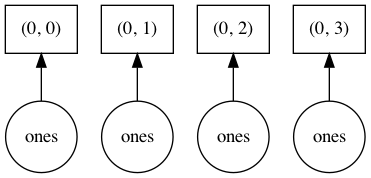

In [7]:
# visualize task graph 
# note: you need the package graphviz to generate this visualization
ones_da.visualize()

So, how does chunking affect the computation? Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array. This is what happens when we call the `.compute()` function:

In [8]:
# compute
ones_da.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Typically, when working with `dask` arrays, we do not want to generate the data right away by calling `.compute()` on a large array. We usually want to perform some computations that reduce the data size. For example, we might compute statistics like the mean or standard deviation.

Let's look at an example of taking the mean and visualize the task graph. Remember, that no actual computation is taking place until we call `.compute()`.

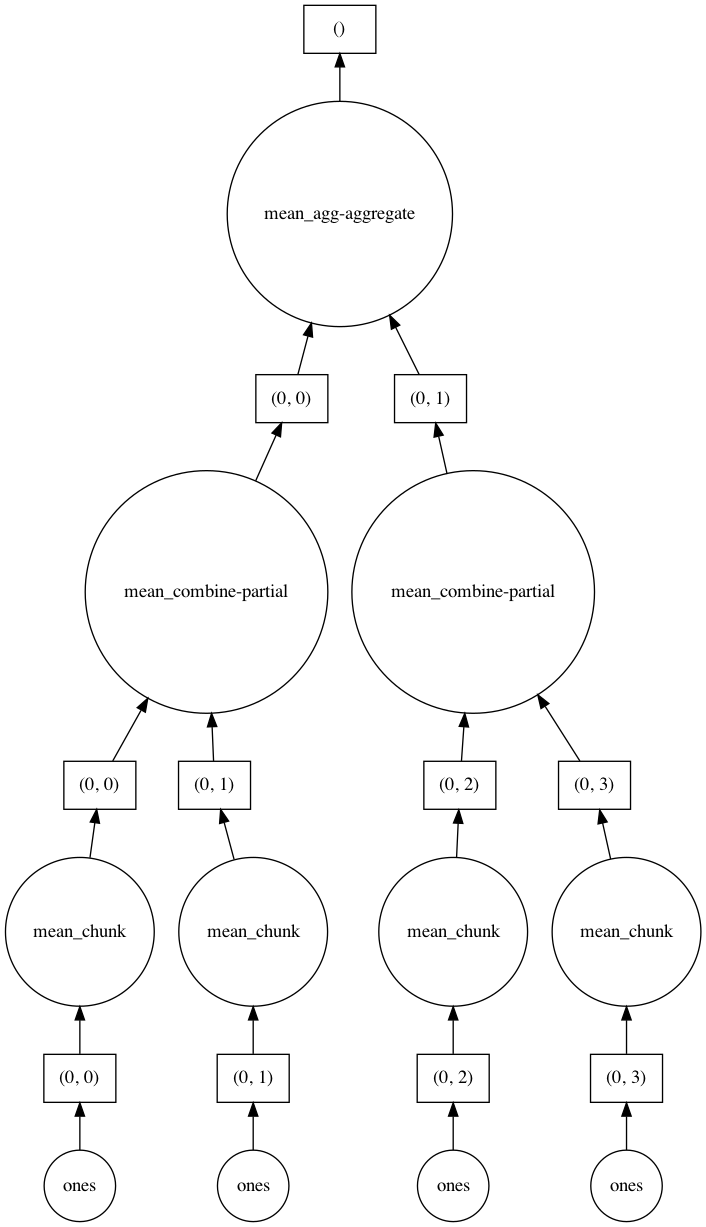

In [9]:
mean_of_ones_da = ones_da.mean()
mean_of_ones_da.visualize()

## Bigger Data

The previous example illustrated how `dask` works, but wasn't really necessary for an array of size 32 MB. Let's try an example using bigger data: 3.2 GB:

In [10]:
bigshape = (200000, 2000)
big_ones_da = da.ones(bigshape,chunks=chunk_shape)
big_ones_da

,Array,Chunk
Bytes,3.20 GB,8.00 MB
Shape,"(200000, 2000)","(1000, 1000)"
Count,400 Tasks,400 Chunks
Type,float64,numpy.ndarray


In [11]:
# size of data
big_ones_da.nbytes / 1e6

3200.0

This dataset is 3.2 GB, rather than MB! This may be close to the available memory/RAM that you have in your computer. 

**Do not try to `.visualize()` this array!**

Bigger computations can take a bit more time, so `dask` has some built-in tools to help us follow what is happening.

In [12]:
# perform big computation
from dask.diagnostics import ProgressBar

big_calc = (big_ones_da * big_ones_da).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  2.3s


1.0

All the usual numpy functions work on `dask` arrays and the computations with remain *lazy* until you either call `.compute()`, `.load()` or your want to plot the data.

In [13]:
# example of using numpy functions in lazy mode
big_ones_eg = (np.cos(big_ones_da)**2).mean(axis=0)
big_ones_eg

dask.array<mean_agg-aggregate, shape=(2000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

If we want to plot the above, we will trigger computation:

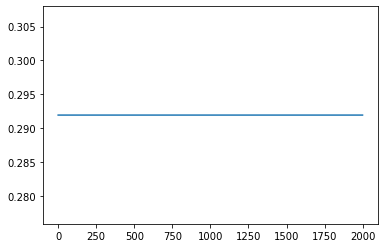

In [14]:
from matplotlib import pyplot as plt
plt.plot(big_ones_eg)

## Distributed Clusters

For data that is much larger than what your computer can handle in memory, we need to use a distributed cluster. We can do this using `dask`.

### Local Cluster

A local cluster uses all the CPU cores of the machine it is running on. For your laptop, you may have 2 to 8 cores. But, if you have access to a larger machine this can be very powerful.

So, let's setup a local cluster using `dask`:

In [15]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:59515 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


Note that there is a Dashboard link that you can open is a separate tab on monitor your computation's progress.

Let's revisit our big calculation example above and call `.compute()`. Watch the Dashboard while the computation is executing.

In [17]:
big_calc.compute()

1.0

Let's try one more even *bigger* computation. We will compute the histogram of some normally distributed data:

In [25]:
# generate array of random normal data
random_values = da.random.normal(size=(2e8,),chunks=(1e6,))
random_values

,Array,Chunk
Bytes,1.60 GB,8.00 MB
Shape,"(200000000,)","(1000000,)"
Count,200 Tasks,200 Chunks
Type,float64,numpy.ndarray


In [26]:
# call histogram function in lazy mode
hist,bins = da.histogram(random_values,bins=100,range=[-5,5])
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

Now, we actually perform the computation. Watch the Dashboard again to follow the computation as it progresses:

In [27]:
# compute
hist_c = hist.compute()

Finally, we can plot the result:

<BarContainer object of 100 artists>

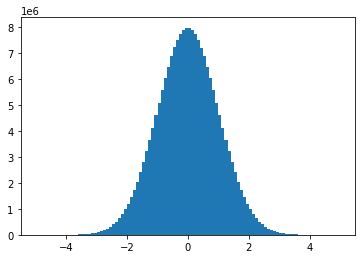

In [30]:
# plot histogram
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.bar(x, hist_c, width)

There are many more options for [distributed computing with `dask`](https://distributed.dask.org/en/stable/). Here we only employed the local cluster option.